# TMA4205 project part 2 - Ottar Hellan

The multigrid methods are implemented in the attached python file ```multigrid.py```.


## Introduction
In this project we implement multigrid methods for solving the Dirichlet Poisson problem on the unit square
\begin{align*}
    -\nabla^2 u & = f, \text{ on } \Omega = (0,1) \times (0,1) \\
    u & = g, \text{ on } \partial\Omega.
\end{align*}
We present an iterative multigrid V-cycle method and a conjugate gradient method using a multigrid V-cycle as a preconditioner. In all numerical experiments the relative tolerance $ || r ||_2 / || r_0 ||_2 = 10^{-12}$ is used.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from multigrid import *
from time import time

## 1
For this project we have implemented a tailored conjugate gradient method specifically for the 2D unit square Poisson problem that works directly on the grid. This CG-method is an integral part to the multigrid method we later develop. 

We test our homemade CG-method on the test problem
\begin{align*}
    -\nabla^2 u & = f = 20\pi^2 \sin(2\pi x) \sin(4\pi y), \, \text{ on } \Omega = (0,1)\times(0,1) \\
    u & = g = \sin(2\pi x) \sin(4\pi y),\text{ on } \partial\Omega.
\end{align*}
Simple calculations confirm that $u = g$ on $\Omega$ is a solution of this problem.

The following code block solves the above problem on grid sizes $N = 32, \, 64, \, 128$ and plots the solutions along with the convergence history.

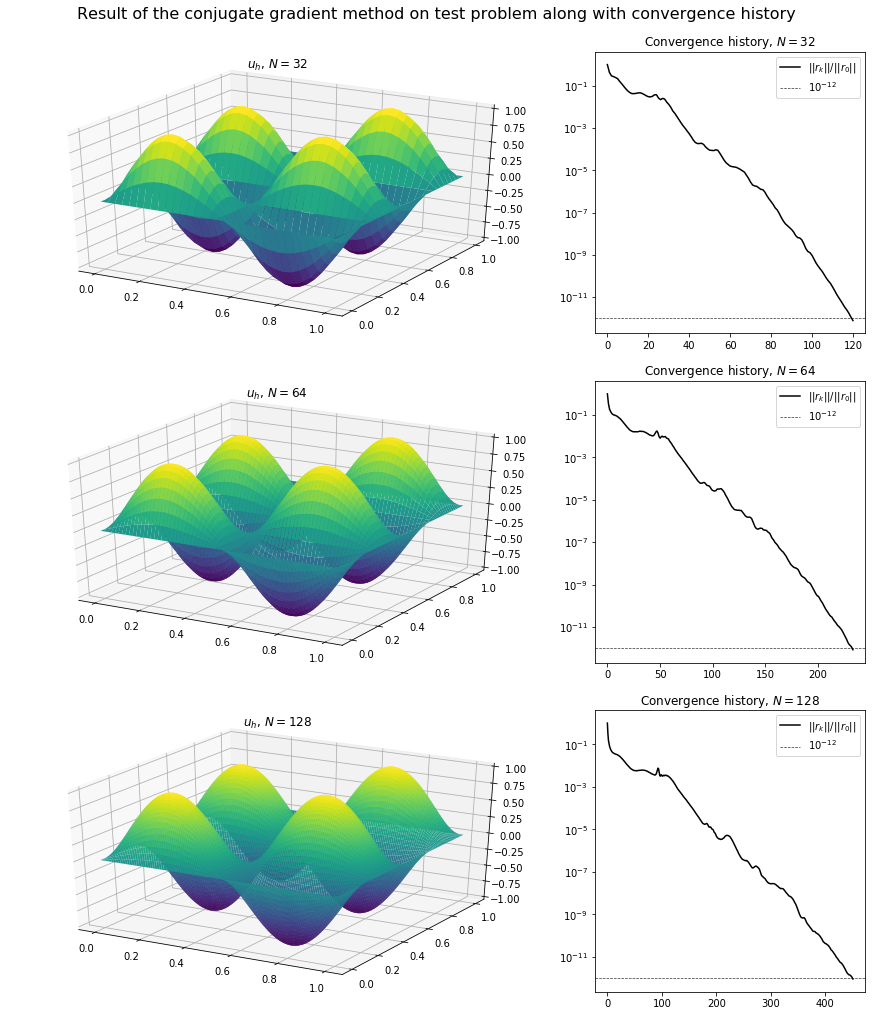

In [11]:
f = lambda x, y: 20*np.pi**2 * np.sin(2*np.pi*x) * np.sin(4*np.pi*y)
g = lambda x, y: np.sin(2*np.pi*x) * np.sin(4*np.pi*y)
u_ex = lambda x, y: np.sin(2*np.pi*x) * np.sin(4*np.pi*y)

ns_array = []
uh_array = []

Ns = [32, 64, 128]
for N in Ns:
    
    x = np.outer(np.linspace(0, 1, N+1), np.ones(N+1))
    y = np.outer(np.ones(N+1), np.linspace(0, 1, N+1))

    b = g(x, y)
    b[1:-1, 1:-1] = f(x[1:-1, 1:-1], y[1:-1, 1:-1])

    u0 = g(x, y)
    np.random.seed(seed=1)
    u0[1:-1, 1:-1] = 1 - 0.5*np.random.random((N-1,N-1))

    s = 1
    uh, i, ns = my_cg(u0, b, N, max_iter=1000)
    
    ns = np.array(ns, dtype=float)    
    ns_array.append(ns)
    uh_array.append(uh)
    
fig = plt.figure(constrained_layout=True, figsize=(12,14))
gs = fig.add_gridspec(3, 3)
fig.suptitle('Result of the conjugate gradient method on test problem along with convergence history',
             fontsize=16)
for i, (uh, ns) in enumerate(zip(uh_array, ns_array)):
    k = uh.shape[0]
    xx = np.outer(np.linspace(0, 1, k), np.ones(k))
    yy = np.outer(np.ones(k), np.linspace(0, 1, k))
    ax = fig.add_subplot(gs[i,:2], projection='3d')
    surf = ax.plot_surface(xx, yy, uh,
                        rstride=1, cstride=1, 
                        cmap=matplotlib.cm.viridis, label=f'$u_{i}$')
    ax.set_title(f'$u_h,\, N = {uh.shape[0] - 1}$')
    
    ax = fig.add_subplot(gs[i,2])
    ax.semilogy(range(len(ns)), ns / ns[0], 'k-', label=r'$||r_k|| / ||r_0||$')
    ax.axhline(y=1e-12, color='black', linestyle='dashed', linewidth='0.7', alpha=0.8,
               label=r'$10^{-12}$')
    ax.set_title(f'Convergence history, $N = {uh.shape[0] - 1}$')
    ax.legend()

    
plt.show();

    

As can be seen in the above figures, the implemented conjugate gradient method converges to the desired tolerance for $N = 32, \, 64, \, 128$. The number of iterations to converge also approximately doubles when the problem size doubles, suggesting a $\mathcal{O}(n)$ convergence on this test problem.

## 2

The multigrid V-cycle method is an iterative method where in each iteration a recursive algorithm is executed on a set number of grids of varying fineness. The cycle begins on the finest grid and descends recursively by restricting the current solution until the coarsest grid is reached, where the problem is solved exactly or by iterative methods. The solution is then sent up the chain again by interpolation of the current solution. On the way down, $\nu_1$ iterations of a fixed point iteration are performed as smoothing before the current solution is restricted. On the way up again, $\nu_2$ iterations of the fixed point iteration are performed as smoothing before the current solution is interpolated and sent up the chain.

In our V-cycle implementation we use the conjugate gradient method with a set relative tolerance $\mathrm{cg.tol}$ on the coarsest grid and the weighted Jacobi iterative method with $\omega = 2/3$ for smoothing.

We test our V-cycle multigrid method on a test problem defined by
\begin{align*}
    -\nabla^2 u & = f = -1, \text{ on } \Omega = (0,1)\times(0,1) \\
    u & = g,\text{ on } \partial\Omega \\
    g(0,y) & = 4\, y\, (1-y), \text{ else } g = 0.
\end{align*}

We use the parameters
\begin{align}
    & \mathrm{levels} & = & & 4\\
    & \nu_1 & = & & 4 \\
    & \nu_2 & = & & 4  \\
    & \mathrm{cg.tol} & = & & 10^{-12}  
\end{align}
in each multigrid V-cycle for this test.

The following code block solves the above problem on a grid of size $N = 32$ and plots the initial guess and the first five iterates of the method along with the convergence history. Additionally, the number of iterations and runtime needed to converge is presented for $N = 2^n$ for $n$ from 5 to 9.

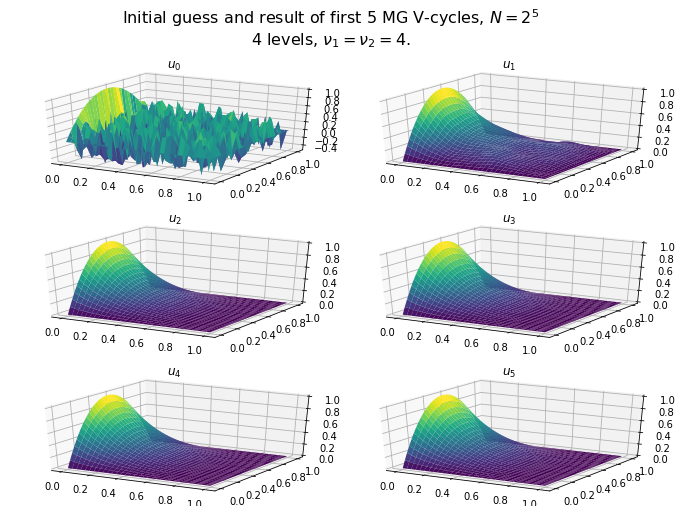

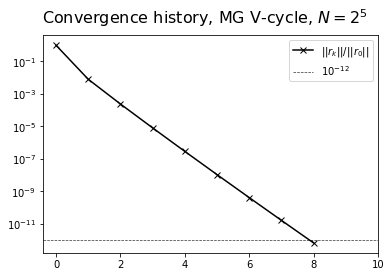

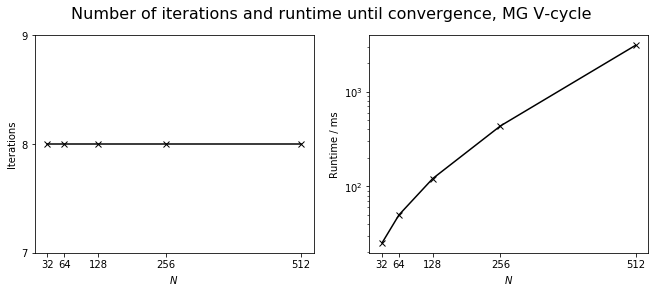

In [23]:
"""
    Test of our multigrid V-cycle method on a simple test problem with constant laplacian
    and non-homogeneous Dirichlet boundary conditions.
"""

f = lambda x, y: 0*x - 1
g = lambda x, y: np.where(x == 0, 4*y*(1-y), 0*x)


N          = 2**5
levels     = 4
nu1        = 4
nu2        = 4
tol        = 1e-12
max_iter   = 100
cg_tol     = 1e-7
cg_maxiter = 400

x = np.outer(np.linspace(0, 1, N+1), np.ones(N+1))
y = np.outer(np.ones(N+1), np.linspace(0, 1, N+1))

rhs = g(x, y)
rhs[1:-1, 1:-1] = f(x[1:-1, 1:-1], y[1:-1, 1:-1])

np.random.seed(seed=1)
u0 = np.copy(rhs)
u0[1:-1,1:-1] = 0.5 - np.random.random((N-1, N-1))

start = time()
uh, i, ns, uh_arr = mgv_iteration_steps(u0, rhs, N, nu1, nu2, level=1, max_level=levels,
                                        tol=tol, max_iter=max_iter, cg_tol=cg_tol,
                                        cg_maxiter=cg_maxiter)
end = time()
runtime = end - start

K = len(uh_arr[:5+1])
s = 2
fig = plt.figure(figsize=(12,8))
fig.suptitle('Initial guess and result of first 5 MG V-cycles, $N = 2^5$ \n4 levels,' + 
             f' $\\nu_1 = \\nu_2 = {nu1}$.', fontsize=16)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0, hspace=None)
for i, uh in enumerate(uh_arr[:5+1]):
    k = uh.shape[0]
    xx = np.outer(np.linspace(0, 1, k), np.ones(k))
    yy = np.outer(np.ones(k), np.linspace(0, 1, k))
    ax = fig.add_subplot(K//2 + K%2, 2, i+1, projection='3d')
    surf = ax.plot_surface(xx, yy, uh,
                        rstride=1, cstride=1, 
                        cmap=matplotlib.cm.viridis, label=f'$u_{i}$')
    ax.set_title(f'$u_{i}$')


fig = plt.figure()
fig.suptitle('Convergence history, MG V-cycle, $N=2^5$', fontsize=16)
ns = np.array(ns, dtype=float)
plt.semilogy(range(len(ns)), ns / ns[0], 'k-x', label=r'$||r_k|| / ||r_0||$')
plt.axhline(y=1e-12, color='black', linestyle='dashed', linewidth='0.7', alpha=0.8,
            label=r'$10^{-12}$')
plt.legend()
plt.xticks([i for i in range(0, 12, 2)])

iters = []
runtimes = []
Ns = [2**i for i in range(5, 9+1)]
for N in Ns:
    print('\r' + ' '*10 + '\r' + f'N = {N}', end='')
    x = np.outer(np.linspace(0, 1, N+1), np.ones(N+1))
    y = np.outer(np.ones(N+1), np.linspace(0, 1, N+1))

    rhs = g(x, y)
    rhs[1:-1, 1:-1] = f(x[1:-1, 1:-1], y[1:-1, 1:-1])

    np.random.seed(seed=1)
    u0 = np.copy(rhs)
    u0[1:-1,1:-1] = 0.5 - np.random.random((N-1, N-1))

    start = time()
    uh, i, ns, uh_arr = mgv_iteration_steps(u0, rhs, N, nu1, nu2, level=1, max_level=levels,
                                            tol=tol, max_iter=max_iter, cg_tol=cg_tol,
                                            cg_maxiter=cg_maxiter)
    end = time()
    runtime = end - start
    
    iters.append(i)
    runtimes.append(runtime)
print('\r' + ' '*10 + '\r', end='')

Ns = np.array(Ns, dtype=int)
iters = np.array(iters, dtype=int)
runtimes = np.array(runtimes, dtype=float)


fig, axs = plt.subplots(1,2, figsize=(11,4))
fig.suptitle('Number of iterations and runtime until convergence, MG V-cycle', fontsize=16)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=None)
axs[0].plot(Ns, iters, 'k-x')
axs[0].set_yticks([7, 8, 9])
axs[0].set_xticks([2**i for i in range(5, 9+1)])
axs[0].set_ylabel('Iterations')
axs[0].set_xlabel('$N$')
axs[1].semilogy(Ns, runtimes*1000, 'k-x')
axs[1].set_ylabel('Runtime / ms')
axs[1].set_xlabel('$N$')
axs[1].set_xticks([2**i for i in range(5, 9+1)])

plt.show();

As seen in the figure, the multigrid method used iteratively converges to the solution with the number of steps to converge not increasing with problem size.

## 3

The conjugate gradient method's convergence is highly dependent on the condtioning number of the problem it solves, and therefore benefits well from preconditioning. We implement a version of the preconditioned conjugate gradient method using the multigrid V-cycle as preconditioner. This is to say, that the preconditioning matrix $M^{-1}$ gives $z = M^{-1} r$ as the result of running a multigrid V-cycle with $r$ as right hand side and zero as the initial guess.

We test our multigrid-preconditioned conjugate gradient method on the test problem
\begin{align*}
    -\nabla^2 u & = f = -1, \text{ on } \Omega = (0,1)\times(0,1) \\
    u & = g,\text{ on } \partial\Omega \\
    g(0,y) & = 4\, y\, (1-y), \text{ else } g = 0.
\end{align*}

We use the parameters
\begin{align}
    & \mathrm{levels} & = & & 4\\
    & \nu_1 & = & & 4 \\
    & \nu_2 & = & & 4  \\
    & \mathrm{cg.tol} & = & & 10^{-12}  
\end{align}
in the multigrid V-cycle in each conjugate gradient step for this test.

The following code block solves the above problem on a grid of size $N = 32$ and plots the initial guess and the first five iterates of the method along with the convergence history. Additionally, the number of iterations and runtime needed to converge is presented for $N = 2^n$ for $n$ from 5 to 9.

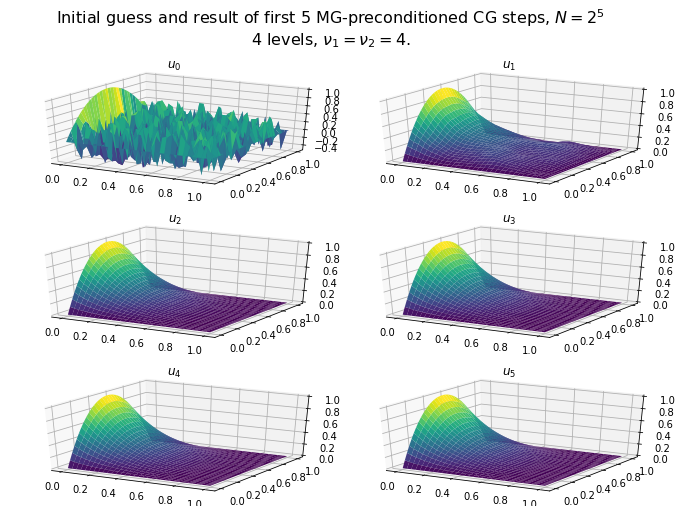

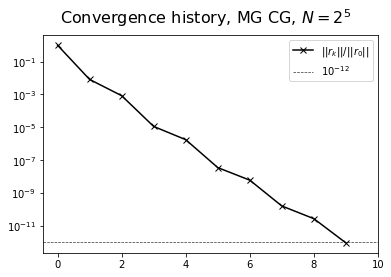

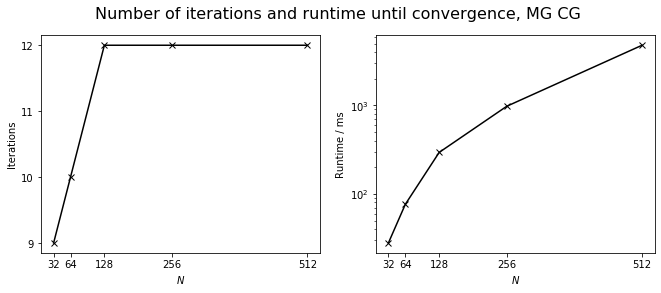

In [24]:
"""
    Test of our multigrid-preconditioned conjugate gradient-method on a simple test problem
    with constant laplacian and non-homogeneous Dirichlet boundary conditions.
"""

f = lambda x, y: 0*x - 1
g = lambda x, y: np.where(x == 0, 4*y*(1-y), 0*x)


N          = 2**5
levels     = 4
nu1        = 4
nu2        = 4
tol        = 1e-12
max_iter   = 1000
cg_tol     = 1e-12
cg_maxiter = 1000

x = np.outer(np.linspace(0, 1, N+1), np.ones(N+1))
y = np.outer(np.ones(N+1), np.linspace(0, 1, N+1))

rhs = g(x, y)
rhs[1:-1, 1:-1] = f(x[1:-1, 1:-1], y[1:-1, 1:-1])

np.random.seed(seed=1)
u0 = np.copy(rhs)
u0[1:-1,1:-1] = 0.5 - np.random.random((N-1, N-1))

start = time()
uh, i, ns, uh_arr = pcg_steps(u0, rhs, N, nu1, nu2, level=1, max_level=levels, tol=tol,
                              max_iter=max_iter, cg_tol=cg_tol, cg_maxiter=cg_maxiter)
end = time()
runtime = end - start

s = 2
fig = plt.figure(figsize=(12,8))
fig.suptitle('Initial guess and result of first 5 MG-preconditioned CG steps, $N = 2^5$' + 
             f' \n{levels} levels, $\\nu_1 = \\nu_2 = {nu1}$.', fontsize=16)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0, hspace=None)
for i, uh in enumerate(uh_arr[:5+1]):
    k = uh.shape[0]
    xx = np.outer(np.linspace(0, 1, k), np.ones(k))
    yy = np.outer(np.ones(k), np.linspace(0, 1, k))
    ax = fig.add_subplot(3, 2, i+1, projection='3d')
    surf = ax.plot_surface(xx, yy, uh,
                        rstride=1, cstride=1, 
                        cmap=matplotlib.cm.viridis, label=f'$u_{i}$')
    ax.set_title(f'$u_{i}$')
    
fig = plt.figure()
fig.suptitle('Convergence history, MG CG, $N=2^5$', fontsize=16)
ns = np.array(ns, dtype=float)
plt.semilogy(range(len(ns)), ns / ns[0], 'k-x', label=r'$||r_k|| / ||r_0||$')
plt.axhline(y=1e-12, color='black', linestyle='dashed', linewidth='0.7', alpha=0.8,
            label=r'$10^{-12}$')
plt.legend()
plt.xticks([i for i in range(0, 12, 2)])


iters = []
runtimes = []
Ns = [2**i for i in range(5, 9+1)]
for N in Ns:
    print('\r' + ' '*10 + '\r' + f'N = {N}', end='')
    x = np.outer(np.linspace(0, 1, N+1), np.ones(N+1))
    y = np.outer(np.ones(N+1), np.linspace(0, 1, N+1))

    rhs = g(x, y)
    rhs[1:-1, 1:-1] = f(x[1:-1, 1:-1], y[1:-1, 1:-1])

    np.random.seed(seed=1)
    u0 = np.copy(rhs)
    u0[1:-1,1:-1] = 0.5 - np.random.random((N-1, N-1))

    start = time()
    uh, i, ns = pcg(u0, rhs, N, nu1, nu2, level=1, max_level=levels,
                    tol=tol, max_iter=max_iter, cg_tol=cg_tol,
                    cg_maxiter=cg_maxiter)
    end = time()
    runtime = end - start
    
    iters.append(i)
    runtimes.append(runtime)
print('\r' + ' '*10 + '\r', end='')

Ns = np.array(Ns, dtype=int)
iters = np.array(iters, dtype=int)
runtimes = np.array(runtimes, dtype=float)


fig, axs = plt.subplots(1,2, figsize=(11,4))
fig.suptitle('Number of iterations and runtime until convergence, MG CG', fontsize=16)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=None)
axs[0].plot(Ns, iters, 'k-x')
axs[0].set_ylabel('Iterations')
axs[0].set_yticks([9, 10, 11, 12])
axs[0].set_xlabel('$N$')
axs[0].set_xticks([2**i for i in range(5, 9+1)])
axs[1].semilogy(Ns, runtimes*1000, 'k-x')
axs[1].set_ylabel('Runtime / ms')
axs[1].set_xlabel('$N$')
axs[1].set_xticks([2**i for i in range(5, 9+1)])

    
plt.show();


As can be seen in the above figures, the steps to reach convergence in the multigrid-preconditioned conjugate gradient method does not increase with problem size, after stabilizing after the lowest problem sizes. This matches what we found for the iterative multigrid method presented in section 2.

## Conclusion
Both the iterative multigrid method and the multigrid-preconditioned conjugate gradient methods converge in steps independent of problem size. On the test problem presented here, the iterative multigrid method performs better, but the multigrid-preconditioned conjugate gradient method is still competitive. Further work remains to investigate if the iterative method is better across a wider range of problems.